In [109]:
import pandas as pd
import numpy as np
import glob
import os


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
mpl.rc('legend',**{'fontsize':16.5})
mpl.rc('lines', linewidth=2)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import xgboost as xgb
from xgboost import XGBRegressor


def save_fig(fig_id, tight_layout=True):
    path = os.path.join(fig_id + ".png") 
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)   


In [2]:
orig_headers = [
    'CREDIT SCORE', 'FIRST PAYMENT DATE', 'FIRST TIME HOMEBUYER FLAG', 'MATURITY DATE',
    'MSA', 'MI %', 'NUMBER OF UNITS', 'OCCUPANCY STATUS', 'ORIGINAL CLTV',
    'ORIGINAL DTI', 'ORIGINAL UPB', 'ORIGINAL LTV', 'ORIGINAL INTEREST RATE',
    'CHANNEL', 'PPM FLAG', 'PRODUCT TYPE', 'PROPERTY STATE', 'PROPERTY TYPE', 
    'POSTAL CODE', 'LOAN SEQUENCE NUMBER', 'LOAN PURPOSE', 'ORIGINAL LOAN TERM',
    'NUMBER OF BORROWERS', 'SELLER NAME', 'SERVICER NAME', 'UNKNOWN'
]

mp_headers = [
    'LOAN SEQUENCE NUMBER', 'MONTHLY REPORTING PERIOD', 'CURRENT ACTUAL UPB',
    'CURRENT LOAN DELINQUENCY STATUS', 'LOAN AGE', 'REMAINING MONTHS TO LEGAL MATURITY',
    'REPURCHASE FLAG', 'MODIFICATION FLAG', 'ZERO BALANCE CODE',
    'ZERO BALANCE EFFECTIVE DATE', 'CURRENT INTEREST RATE', 'CURRENT DEFERRED UPB', 
    'DDLPI', 'MI RECOVERIES', 'NET SALES PROCEEDS', 'NON MI RECOVERIES', 'EXPENSES', 
    'LEGAL COSTS', 'MAINTENANCE AND PRESERVATION COSTS', 'TAXES AND INSURANCE', 
    'MISCELLANEOUS EXPENSES', 'ACTUAL LOSS CALCULATION', 'MODIFICATION COST',
    'STEP MODIFICATION FLAG', 'DEFERRED PAYMENT MODIFICATION', 'ELTV', 'ZERO BALANCE REMOVAL UPB',
    'DELINQUENT ACCRUED INTEREST'
]


In [3]:
cols_orig = [
    'CREDIT SCORE', 'FIRST TIME HOMEBUYER FLAG', 'FIRST PAYMENT DATE',
    'MI %', 'NUMBER OF UNITS', 'OCCUPANCY STATUS', 'ORIGINAL CLTV',
    'ORIGINAL DTI', 'ORIGINAL UPB', 'ORIGINAL INTEREST RATE',
    'CHANNEL', 'PROPERTY TYPE', 'LOAN SEQUENCE NUMBER', 'SELLER NAME', 'SERVICER NAME',
    'LOAN PURPOSE', 'ORIGINAL LOAN TERM', 'NUMBER OF BORROWERS', 'PROPERTY STATE'
]

cols_mp = ['LOAN SEQUENCE NUMBER', 'LOAN AGE', 'ZERO BALANCE CODE']


In [4]:
def mp_concatter(indir, outdir):
    filelist = glob.glob(indir)
    dflist = []
    for file in filelist:
        print(file)
        data = pd.read_csv(file, delimiter='|', names=mp_headers, low_memory=False)
        data = data[cols_mp]
        data.dropna(inplace=True)
        dflist.append(data)
    print("now concat")
    concatdf = pd.concat(dflist, axis=0)
    concatdf.to_csv(outdir, index=False)
    print("finished")
    
    
# mp_concatter('data/mp/*.txt', 'data/mp.csv')
# mp_concatter('data/mp/*.txt', 'data/mp2.csv')

In [5]:
def orig_concatter(path, file):
    files = glob.glob(path)

    with open('data/orig2.txt','w') as result:
        for file_ in files:
            for line in open(file_, 'r'):
                result.write(line)
                

# orig_concatter('data/orig/*.txt', 'data/orig.txt')
# orig_concatter('data/orig2/*.txt', 'data/orig2.txt')

In [6]:
def cleaner_combiner(mp, orig):
    data = mp.set_index('LOAN SEQUENCE NUMBER').join(orig.set_index('LOAN SEQUENCE NUMBER'))
    data.dropna(inplace=True)
    data = data[(data['CREDIT SCORE'] >= 301) & (data['CREDIT SCORE'] <= 850)]
    data = data[(data['ORIGINAL CLTV'] >= 0) & (data['ORIGINAL CLTV'] <= 200)]
    data = data[(data['ORIGINAL DTI'] >= 0) & (data['ORIGINAL DTI'] <= 65)]
    data['MI %'].replace(999, 0, inplace=True)
    data['ZERO BALANCE CODE'].replace({1: 0, 9: 1, 6: 1, 3: 1, 2: 1, 15: 1}, inplace=True)
    return data


In [7]:
orig_ = pd.read_csv('data/orig.txt', delimiter='|', names=orig_headers, low_memory=False)
orig2_ = pd.read_csv('data/orig2.txt', delimiter='|', names=orig_headers, low_memory=False)

In [8]:
mp_ = pd.read_csv('data/mp.csv', low_memory=False)
mp2_ = pd.read_csv('data/mp2.csv', low_memory=False)

In [9]:
orig = orig_[cols_orig]
orig2 = orig2_[cols_orig]

In [10]:
mp = mp_[cols_mp]
mp2 = mp2_[cols_mp]

In [11]:
dummy_cols = ['FIRST TIME HOMEBUYER FLAG', 'OCCUPANCY STATUS', 'CHANNEL', 
              'PROPERTY TYPE', 'LOAN PURPOSE', 'SELLER NAME', 'SERVICER NAME', 'PROPERTY STATE']

def get_dummies_(X, dummy_cols):
    dummies = pd.get_dummies(X[dummy_cols])
    X = X.merge(dummies, left_index=True, right_index=True)
    X = X.drop(dummy_cols, axis=1)
    return X


In [21]:
data = cleaner_combiner(mp, orig)
data2 = cleaner_combiner(mp2, orig2)

In [22]:
data = get_dummies_(data, dummy_cols)
data2 = get_dummies_(data2, dummy_cols)

In [23]:
train = data[(data['FIRST PAYMENT DATE'] < 201701)]
train2 = data2[(data2['FIRST PAYMENT DATE'] < 201701)]

In [24]:
test = data[(data['FIRST PAYMENT DATE'] >= 201701)]
test2 = data2[(data2['FIRST PAYMENT DATE'] >= 201701)]

In [25]:
train = train.drop(['FIRST PAYMENT DATE'], axis=1)
test = test.drop(['FIRST PAYMENT DATE'], axis=1)

train2 = train2.drop(['FIRST PAYMENT DATE'], axis=1)
test2 = test2.drop(['FIRST PAYMENT DATE'], axis=1)

In [26]:
print(train.shape)
train.head()

(659007, 161)


,LOAN AGE,ZERO BALANCE CODE,CREDIT SCORE,MI %,NUMBER OF UNITS,ORIGINAL CLTV,ORIGINAL DTI,ORIGINAL UPB,ORIGINAL INTEREST RATE,ORIGINAL LOAN TERM,NUMBER OF BORROWERS,FIRST TIME HOMEBUYER FLAG_9,FIRST TIME HOMEBUYER FLAG_N,FIRST TIME HOMEBUYER FLAG_Y,OCCUPANCY STATUS_I,OCCUPANCY STATUS_P,OCCUPANCY STATUS_S,CHANNEL_B,CHANNEL_C,CHANNEL_R,PROPERTY TYPE_CO,PROPERTY TYPE_CP,PROPERTY TYPE_MH,PROPERTY TYPE_PU,PROPERTY TYPE_SF,...,PROPERTY STATE_ND,PROPERTY STATE_NE,PROPERTY STATE_NH,PROPERTY STATE_NJ,PROPERTY STATE_NM,PROPERTY STATE_NV,PROPERTY STATE_NY,PROPERTY STATE_OH,PROPERTY STATE_OK,PROPERTY STATE_OR,PROPERTY STATE_PA,PROPERTY STATE_PR,PROPERTY STATE_RI,PROPERTY STATE_SC,PROPERTY STATE_SD,PROPERTY STATE_TN,PROPERTY STATE_TX,PROPERTY STATE_UT,PROPERTY STATE_VA,PROPERTY STATE_VI,PROPERTY STATE_VT,PROPERTY STATE_WA,PROPERTY STATE_WI,PROPERTY STATE_WV,PROPERTY STATE_WY
LOAN SEQUENCE NUMBER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F115Q1000001,18,0.0,796,0,1,72,21,320000,2.625,180,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F115Q1000008,52,0.0,791,0,1,50,30,80000,4.000,360,2,1,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F115Q1000010,24,0.0,709,0,1,80,38,210000,4.625,360,2,1,0,0,0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F115Q1000011,21,0.0,765,0,1,72,34,81000,3.500,180,2,1,0,0,1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F115Q1000012,17,0.0,788,30,1,92,33,345000,3.875,360,2,1,0,0,0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
print(test.shape)
test.head()

(258660, 161)


,LOAN AGE,ZERO BALANCE CODE,CREDIT SCORE,MI %,NUMBER OF UNITS,ORIGINAL CLTV,ORIGINAL DTI,ORIGINAL UPB,ORIGINAL INTEREST RATE,ORIGINAL LOAN TERM,NUMBER OF BORROWERS,FIRST TIME HOMEBUYER FLAG_9,FIRST TIME HOMEBUYER FLAG_N,FIRST TIME HOMEBUYER FLAG_Y,OCCUPANCY STATUS_I,OCCUPANCY STATUS_P,OCCUPANCY STATUS_S,CHANNEL_B,CHANNEL_C,CHANNEL_R,PROPERTY TYPE_CO,PROPERTY TYPE_CP,PROPERTY TYPE_MH,PROPERTY TYPE_PU,PROPERTY TYPE_SF,...,PROPERTY STATE_ND,PROPERTY STATE_NE,PROPERTY STATE_NH,PROPERTY STATE_NJ,PROPERTY STATE_NM,PROPERTY STATE_NV,PROPERTY STATE_NY,PROPERTY STATE_OH,PROPERTY STATE_OK,PROPERTY STATE_OR,PROPERTY STATE_PA,PROPERTY STATE_PR,PROPERTY STATE_RI,PROPERTY STATE_SC,PROPERTY STATE_SD,PROPERTY STATE_TN,PROPERTY STATE_TX,PROPERTY STATE_UT,PROPERTY STATE_VA,PROPERTY STATE_VI,PROPERTY STATE_VT,PROPERTY STATE_WA,PROPERTY STATE_WI,PROPERTY STATE_WV,PROPERTY STATE_WY
LOAN SEQUENCE NUMBER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F117Q3000001,14,0.0,790,0,1,63,17,315000,4.000,360,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F117Q3000005,6,0.0,751,30,1,95,34,409000,4.000,360,2,0,1,0,0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F117Q3000040,21,0.0,798,12,1,89,21,275000,3.250,180,2,1,0,0,0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F117Q3000042,16,0.0,787,0,1,80,37,208000,4.250,360,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F117Q3000063,8,0.0,748,0,1,25,48,315000,3.875,360,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
print(train2.shape)
train2.head()

(1304534, 274)


,LOAN AGE,ZERO BALANCE CODE,CREDIT SCORE,MI %,NUMBER OF UNITS,ORIGINAL CLTV,ORIGINAL DTI,ORIGINAL UPB,ORIGINAL INTEREST RATE,ORIGINAL LOAN TERM,NUMBER OF BORROWERS,FIRST TIME HOMEBUYER FLAG_9,FIRST TIME HOMEBUYER FLAG_N,FIRST TIME HOMEBUYER FLAG_Y,OCCUPANCY STATUS_I,OCCUPANCY STATUS_P,OCCUPANCY STATUS_S,CHANNEL_B,CHANNEL_C,CHANNEL_R,CHANNEL_T,PROPERTY TYPE_99,PROPERTY TYPE_CO,PROPERTY TYPE_CP,PROPERTY TYPE_MH,...,PROPERTY STATE_ND,PROPERTY STATE_NE,PROPERTY STATE_NH,PROPERTY STATE_NJ,PROPERTY STATE_NM,PROPERTY STATE_NV,PROPERTY STATE_NY,PROPERTY STATE_OH,PROPERTY STATE_OK,PROPERTY STATE_OR,PROPERTY STATE_PA,PROPERTY STATE_PR,PROPERTY STATE_RI,PROPERTY STATE_SC,PROPERTY STATE_SD,PROPERTY STATE_TN,PROPERTY STATE_TX,PROPERTY STATE_UT,PROPERTY STATE_VA,PROPERTY STATE_VI,PROPERTY STATE_VT,PROPERTY STATE_WA,PROPERTY STATE_WI,PROPERTY STATE_WV,PROPERTY STATE_WY
LOAN SEQUENCE NUMBER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F115Q1000001,18,0.0,796,0,1,72,21,320000,2.625,180,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F115Q1000008,52,0.0,791,0,1,50,30,80000,4.000,360,2,1,0,0,0,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F115Q1000010,24,0.0,709,0,1,80,38,210000,4.625,360,2,1,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F115Q1000011,21,0.0,765,0,1,72,34,81000,3.500,180,2,1,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F115Q1000012,17,0.0,788,30,1,92,33,345000,3.875,360,2,1,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
print(test2.shape)
test2.head()

(258660, 274)


,LOAN AGE,ZERO BALANCE CODE,CREDIT SCORE,MI %,NUMBER OF UNITS,ORIGINAL CLTV,ORIGINAL DTI,ORIGINAL UPB,ORIGINAL INTEREST RATE,ORIGINAL LOAN TERM,NUMBER OF BORROWERS,FIRST TIME HOMEBUYER FLAG_9,FIRST TIME HOMEBUYER FLAG_N,FIRST TIME HOMEBUYER FLAG_Y,OCCUPANCY STATUS_I,OCCUPANCY STATUS_P,OCCUPANCY STATUS_S,CHANNEL_B,CHANNEL_C,CHANNEL_R,CHANNEL_T,PROPERTY TYPE_99,PROPERTY TYPE_CO,PROPERTY TYPE_CP,PROPERTY TYPE_MH,...,PROPERTY STATE_ND,PROPERTY STATE_NE,PROPERTY STATE_NH,PROPERTY STATE_NJ,PROPERTY STATE_NM,PROPERTY STATE_NV,PROPERTY STATE_NY,PROPERTY STATE_OH,PROPERTY STATE_OK,PROPERTY STATE_OR,PROPERTY STATE_PA,PROPERTY STATE_PR,PROPERTY STATE_RI,PROPERTY STATE_SC,PROPERTY STATE_SD,PROPERTY STATE_TN,PROPERTY STATE_TX,PROPERTY STATE_UT,PROPERTY STATE_VA,PROPERTY STATE_VI,PROPERTY STATE_VT,PROPERTY STATE_WA,PROPERTY STATE_WI,PROPERTY STATE_WV,PROPERTY STATE_WY
LOAN SEQUENCE NUMBER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F117Q3000001,14,0.0,790,0,1,63,17,315000,4.000,360,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F117Q3000005,6,0.0,751,30,1,95,34,409000,4.000,360,2,0,1,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F117Q3000040,21,0.0,798,12,1,89,21,275000,3.250,180,2,1,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F117Q3000042,16,0.0,787,0,1,80,37,208000,4.250,360,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F117Q3000063,8,0.0,748,0,1,25,48,315000,3.875,360,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
X = train.drop('ZERO BALANCE CODE', axis=1)
y = train['ZERO BALANCE CODE']

X2 = train2.drop('ZERO BALANCE CODE', axis=1)
y2 = train2['ZERO BALANCE CODE']

In [31]:
X_ = test.drop('ZERO BALANCE CODE', axis=1)
y_ = test['ZERO BALANCE CODE']

X2_ = test2.drop('ZERO BALANCE CODE', axis=1)
y2_ = test2['ZERO BALANCE CODE']


# Undersampling - Random

In [32]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority', random_state=99, replacement=True)
X_under, y_under = undersample.fit_resample(X, y)
X_under_, y_under_ = undersample.fit_resample(X_, y_)
X2_under, y2_under = undersample.fit_resample(X2, y2)
X2_under_, y2_under_ = undersample.fit_resample(X2_, y2_)

/Users/Shaun/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Shaun/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Shaun/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.2

# Undersampling - Cluster

In [34]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(ratio={0: 100}, random_state=99)
X_res, y_res = cc.fit_resample(X, y)
X_res_, y_res_ = cc.fit_resample(X_, y_)
X2_res, y2_res = undersample.fit_resample(X2, y2)
X2_res_, y2_res_ = undersample.fit_resample(X2_, y2_)

/Users/Shaun/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/Shaun/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/Shaun/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/Shaun/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version

# EDA

### Class Imbalance 

Saving figure images/imbalance


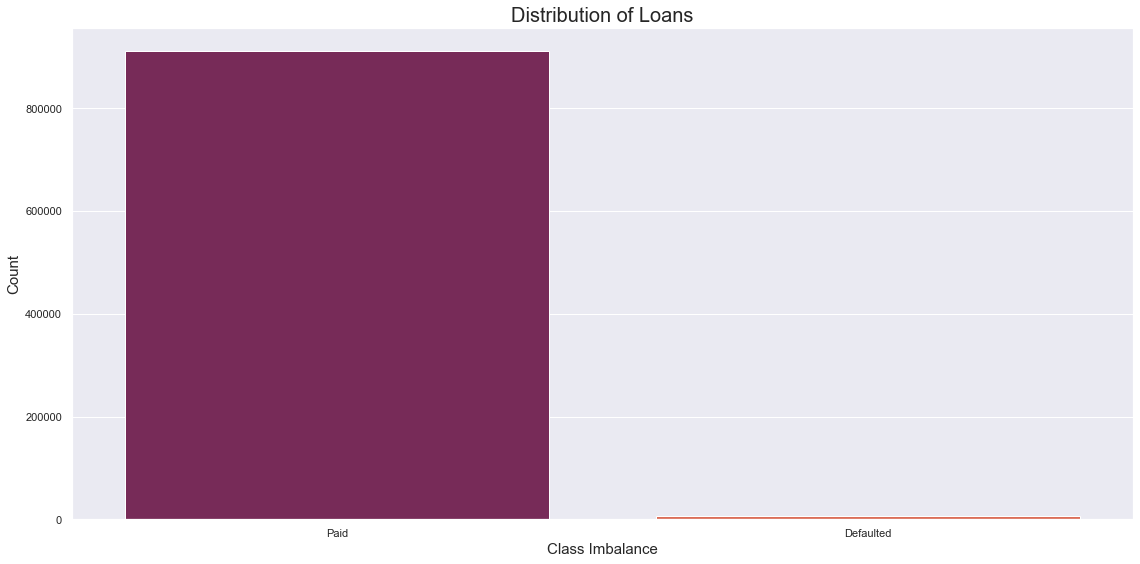

In [139]:
dist = data['ZERO BALANCE CODE'].replace({0: 'Paid', 1: 'Defaulted'})

sns.set(rc={'figure.figsize':(16,8)})
sns.countplot(dist, palette='rocket')
plt.xlabel("Class Imbalance", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribution of Loans", fontsize=20)
save_fig('images/imbalance')
plt.show()


### Class Imbalance - All Defaults

Saving figure images/imbalance_all


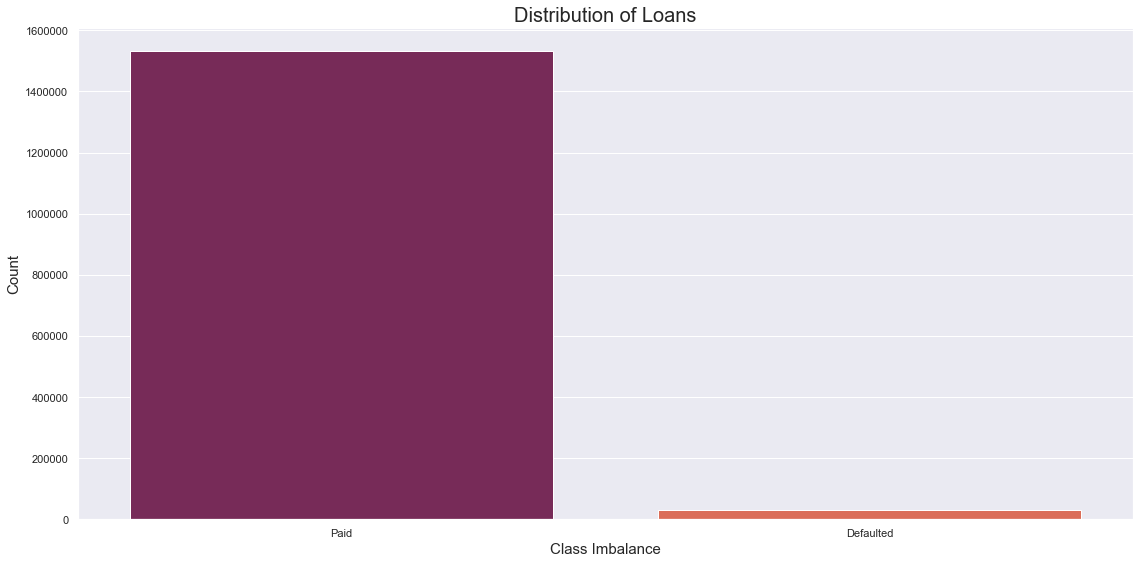

In [140]:
dist2 = data2['ZERO BALANCE CODE'].replace({0: 'Paid', 1: 'Defaulted'})

sns.set(rc={'figure.figsize':(16,8)})
sns.countplot(dist2, palette='rocket')
plt.xlabel("Class Imbalance", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribution of Loans", fontsize=20)
save_fig('images/imbalance_all')
plt.show()


### Class Undersampling

Saving figure images/imbalance_under


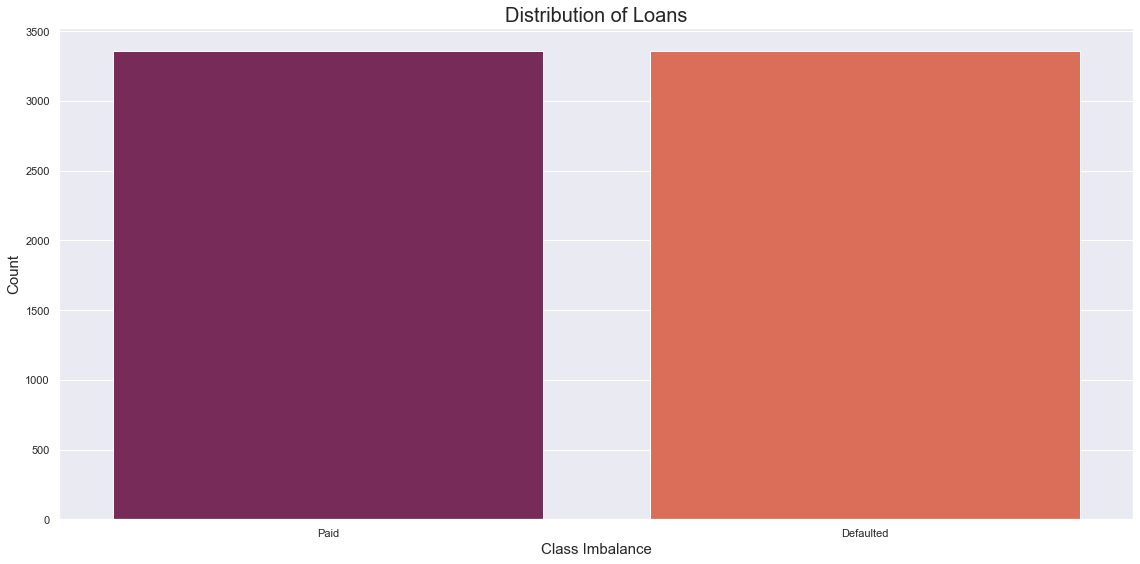

In [141]:
dist_ = pd.DataFrame(y_under)
dist_ = dist_[0].replace({0: 'Paid', 1: 'Defaulted'})

sns.set(rc={'figure.figsize':(16,8)})
sns.countplot(dist_, palette='rocket')
plt.xlabel("Class Imbalance", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribution of Loans", fontsize=20)
save_fig('images/imbalance_under')
plt.show()

### Class Undersampling - All Defaults

Saving figure images/imbalance_all_under


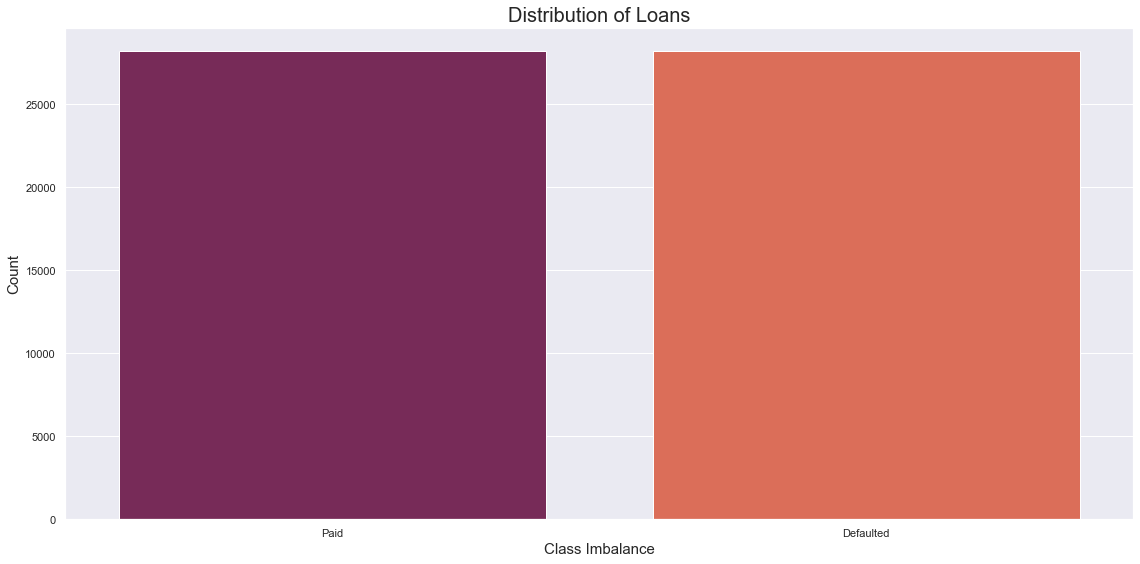

In [142]:
dist2_ = pd.DataFrame(y2_under)
dist2_ = dist2_[0].replace({0: 'Paid', 1: 'Defaulted'})

sns.set(rc={'figure.figsize':(16,8)})
sns.countplot(dist2_, palette='rocket')
plt.xlabel("Class Imbalance", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Distribution of Loans", fontsize=20)
save_fig('images/imbalance_all_under')
plt.show()

Saving figure images/distcr


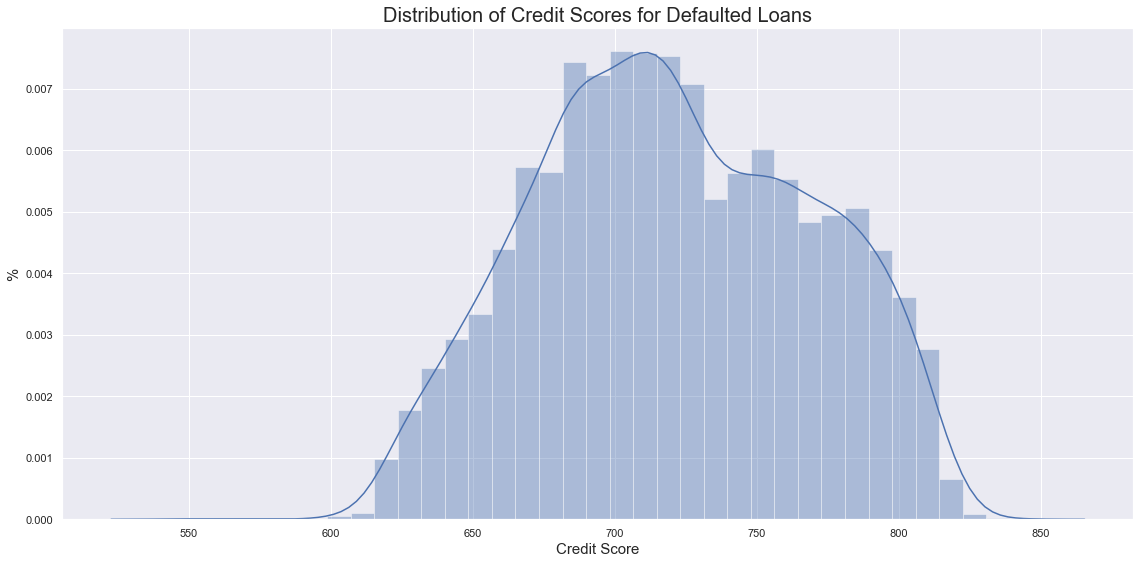

In [143]:
paid = data[data['ZERO BALANCE CODE'] == 0]
default = data[data['ZERO BALANCE CODE'] == 1]

sns.set(rc={'figure.figsize':(16,8)})
sns.distplot(default['CREDIT SCORE'], color='b', bins=35)
plt.xlabel("Credit Score", fontsize=15)
plt.ylabel("%", fontsize=15)
plt.title("Distribution of Credit Scores for Defaulted Loans", fontsize=20)
save_fig('images/distcr')
plt.show()


Saving figure images/distcltv


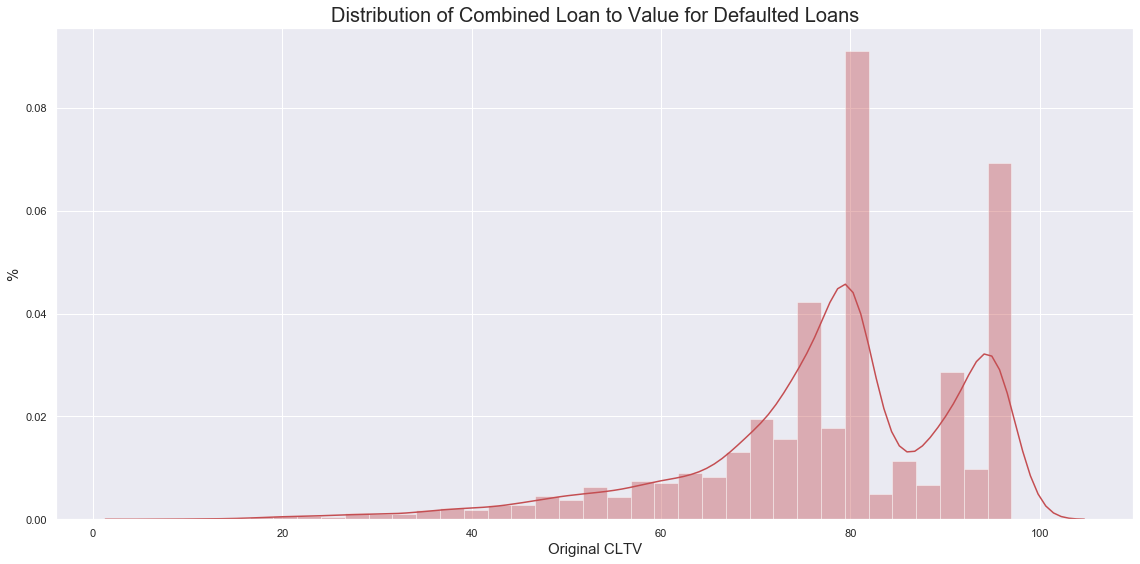

In [144]:

sns.set(rc={'figure.figsize':(16,8)})
sns.distplot(default['ORIGINAL CLTV'], color='r', bins=35)
plt.xlabel("Original CLTV", fontsize=15)
plt.ylabel("%", fontsize=15)
plt.title("Distribution of Combined Loan to Value for Defaulted Loans", fontsize=20)
save_fig('images/distcltv')
plt.show()


Saving figure images/distir


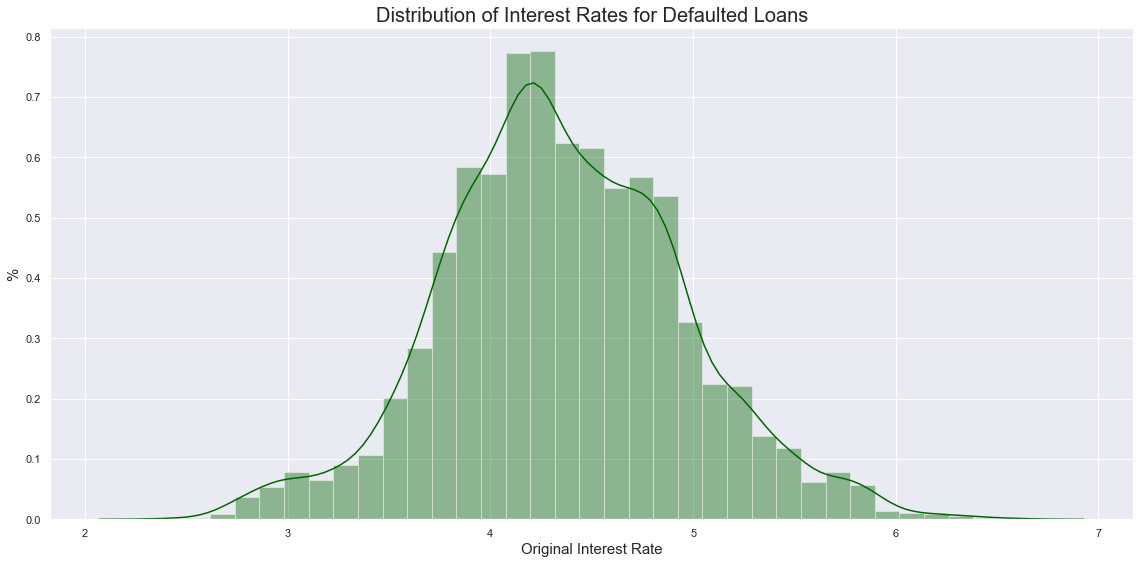

In [145]:

sns.set(rc={'figure.figsize':(16,8)})
sns.distplot(default['ORIGINAL INTEREST RATE'], color='darkgreen', bins=35)
plt.xlabel("Original Interest Rate", fontsize=15)
plt.ylabel("%", fontsize=15)
plt.title("Distribution of Interest Rates for Defaulted Loans", fontsize=20)
save_fig('images/distir')
plt.show()

Saving figure images/distdti


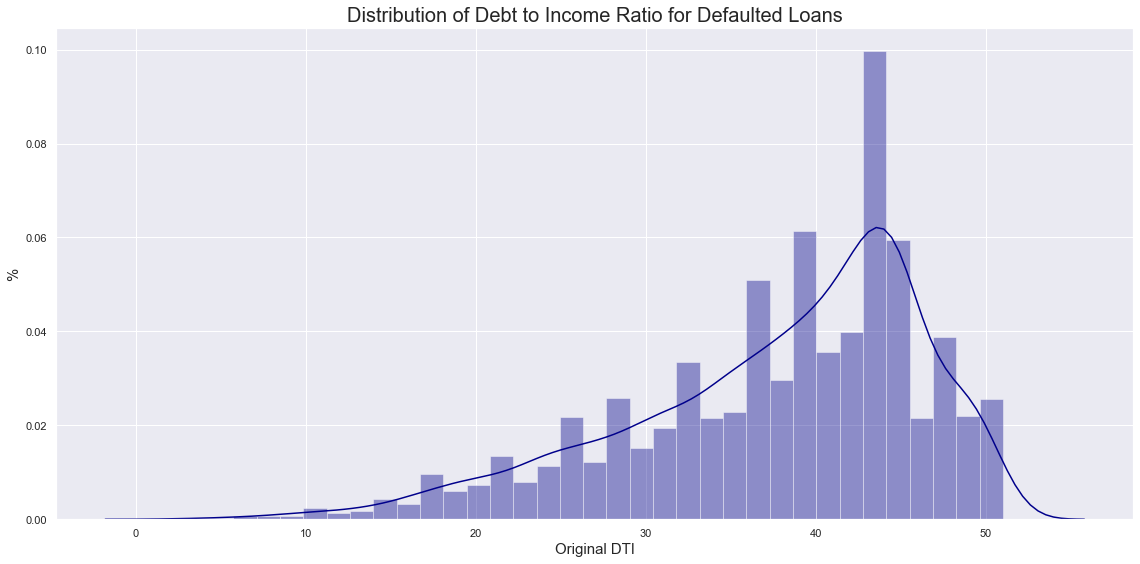

In [146]:

sns.set(rc={'figure.figsize':(16,8)})
sns.distplot(default['ORIGINAL DTI'], color='darkblue', bins=35)
plt.xlabel("Original DTI", fontsize=15)
plt.ylabel("%", fontsize=15)
plt.title("Distribution of Debt to Income Ratio for Defaulted Loans", fontsize=20)
save_fig('images/distdti')
plt.show()

In [136]:
def model_train_test(X_train, X_test, y_train, y_test, X_, y_, title_train, title_test, save_train, save_test):
    
    # logreg
    pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(random_state=99, max_iter=1000))
    pipe_lr.fit(X_train, y_train)
    test_probas_lr = pipe_lr.predict_proba(X_test)[:,1]
    
    # rand forest
    pipe_rfc = make_pipeline(StandardScaler(), RandomForestClassifier(
        oob_score=True, n_jobs=-1, max_depth=5, random_state=99))
    pipe_rfc.fit(X_train, y_train)
    test_probas_rfc = pipe_rfc.predict_proba(X_test)[:,1]
    
    # gradboost
    pipe_gbc = make_pipeline(StandardScaler(), GradientBoostingClassifier(learning_rate=0.2, random_state=99))
    pipe_gbc.fit(X_train, y_train)
    test_probas_gbc = pipe_gbc.predict_proba(X_test)[:,1]
    
    # naive
    pipe_nb = make_pipeline(StandardScaler(), BernoulliNB())
    pipe_nb.fit(X_train, y_train)
    test_probas_nb = pipe_nb.predict_proba(X_test)[:,1]
    
    # XGBoost
    pipe_xgb = make_pipeline(StandardScaler(), XGBRegressor(
    base_score=0.5, booster='gbtree', colsample_bylevel=1,
    colsample_bynode=1, colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
    importance_type='gain', interaction_constraints='',
    learning_rate=0.05, max_delta_step=0, max_depth=12,
    min_child_weight=7, monotone_constraints='()',
    n_estimators=100, n_jobs=0, num_parallel_tree=1,
    objective='binary:logistic', random_state=0, reg_alpha=0,
    reg_lambda=1, scale_pos_weight=1, subsample=1,
    tree_method='exact', validate_parameters=1, verbosity=None, eval_metric='auc'
                         ))
    pipe_xgb.fit(X_train, y_train)
    test_xgb = pipe_xgb.predict(X_test)
    
    # graph
    
    # generate a no skill prediction
    ns_probs = [0 for _ in range(len(y_test))]

    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, test_probas_lr)
    rfc_auc = roc_auc_score(y_test, test_probas_rfc)
    gbc_auc = roc_auc_score(y_test, test_probas_gbc)
    nb_auc = roc_auc_score(y_test, test_probas_nb)
    xgb_auc = roc_auc_score(y_test, test_xgb)

    ns = 'No Skill ROC-AUC score: %.3f' % ns_auc
    lr = 'Logistic Regression ROC-AUC score: %.3f' % lr_auc
    rfc = 'Random Forest Classifier ROC-AUC score: %.3f' % rfc_auc
    gbc = 'Gradient Boost ROC-AUC score: %.3f' % gbc_auc
    nb = 'Bernoulli NB ROC-AUC score: %.3f' % nb_auc
    xgb = 'XGBoost ROC-AUC score: %.3f' % xgb_auc

    print(ns)
    print(lr)
    print(nb)
    print(rfc)
    print(gbc)
    print(xgb)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, test_probas_lr)
    rfc_fpr, rfc_tpr, _ = roc_curve(y_test, test_probas_rfc)
    gbc_fpr, gbc_tpr, _ = roc_curve(y_test, test_probas_gbc)
    nb_fpr, nb_tpr, _ = roc_curve(y_test, test_probas_nb)
    xgb_fpr, xgb_tpr, _ = roc_curve(y_test, test_xgb)

    # fig size
    plt.figure(figsize=(16,8))

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label=ns, color='blue')
    plt.plot(lr_fpr, lr_tpr, linestyle='--', label=lr, color='red')
    plt.plot(nb_fpr, nb_tpr, linestyle='--', label=nb, color='purple')
    plt.plot(rfc_fpr, rfc_tpr, linestyle='--', label=rfc, color='green')
    plt.plot(gbc_fpr, gbc_tpr, linestyle='--', label=gbc, color='orange')
    plt.plot(xgb_fpr, xgb_tpr, linestyle='--', label=xgb, color='black')
    
    plt.title(title_train, fontsize=18)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend(loc='lower right')
    # show the plot
    save_fig(save_train)
    plt.show()    

    test_probas_lrt = pipe_lr.predict_proba(X_)[:,1]
    test_probas_rfct = pipe_rfc.predict_proba(X_)[:,1]
    test_probas_gbct = pipe_gbc.predict_proba(X_)[:,1]
    test_probas_nbt = pipe_nb.predict_proba(X_)[:,1]
    test_xgbt = pipe_xgb.predict(X_)

    # generate a no skill prediction
    nst_probs = [0 for _ in range(len(y_))]

    # calculate scores
    nst_auc = roc_auc_score(y_, nst_probs)
    lrt_auc = roc_auc_score(y_, test_probas_lrt)
    rfct_auc = roc_auc_score(y_, test_probas_rfct)
    gbct_auc = roc_auc_score(y_, test_probas_gbct)
    nbt_auc = roc_auc_score(y_, test_probas_nbt)
    xgbt_auc = roc_auc_score(y_, test_xgbt)


    nst = 'No Skill ROC-AUC score: %.3f' % nst_auc
    lrt = 'Logistic Regression ROC-AUC score: %.3f' % lrt_auc
    rfct = 'Random Forest Classifier ROC-AUC score: %.3f' % rfct_auc
    gbct = 'Gradient Boost ROC-AUC score: %.3f' % gbct_auc
    nbt = 'Bernoulli NB ROC-AUC score: %.3f' % nbt_auc
    xgbt = 'XGBoost ROC-AUC score: %.3f' % xgbt_auc

    print(nst)
    print(lrt)
    print(nbt)
    print(rfct)
    print(gbct)
    print(xgbt)

    # calculate roc curves
    nst_fpr, nst_tpr, _ = roc_curve(y_, nst_probs)
    lrt_fpr, lrt_tpr, _ = roc_curve(y_, test_probas_lrt)
    rfct_fpr, rfct_tpr, _ = roc_curve(y_, test_probas_rfct)
    gbct_fpr, gbct_tpr, _ = roc_curve(y_, test_probas_gbct)
    nbt_fpr, nbt_tpr, _ = roc_curve(y_, test_probas_nbt)
    xgbt_fpr, xgbt_tpr, _ = roc_curve(y_, test_xgbt)

    # fig size
    plt.figure(figsize=(16,8))

    # plot the roc curve for the model
    plt.plot(nst_fpr, nst_tpr, linestyle='--', label=nst, color='blue')
    plt.plot(lrt_fpr, lrt_tpr, linestyle='--', label=lrt, color='red')
    plt.plot(nbt_fpr, nbt_tpr, linestyle='--', label=nbt, color='purple')
    plt.plot(rfct_fpr, rfct_tpr, linestyle='--', label=rfct, color='green')
    plt.plot(gbct_fpr, gbct_tpr, linestyle='--', label=gbct, color='orange')
    plt.plot(xgbt_fpr, xgbt_tpr, linestyle='--', label=xgbt, color='black')

    plt.title(title_test, fontsize=18)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend(loc='lower right')
    # show the plot
    save_fig(save_test)
    plt.show()
    
    

# Preliminary Approach

### CV score

In [74]:
pipe_lr = make_pipeline(LogisticRegression(random_state=99, max_iter=1000))
                        
cross_val_score(pipe_lr, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
                        

array([0.75913216, 0.76893365, 0.65822882, 0.7605715 , 0.77881656])

### Models

No Skill ROC-AUC score: 0.500
Logistic Regression ROC-AUC score: 0.834
Bernoulli NB ROC-AUC score: 0.763
Random Forest Classifier ROC-AUC score: 0.829
Gradient Boost ROC-AUC score: 0.817
XGBoost ROC-AUC score: 0.879
Saving figure images/AOC_train_prelim


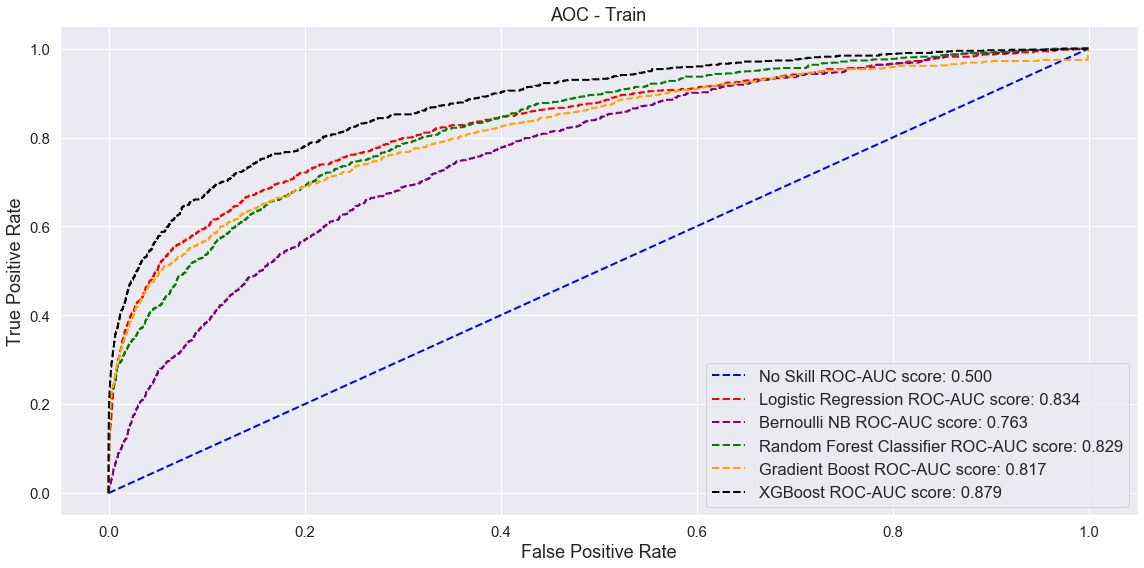

No Skill ROC-AUC score: 0.500
Logistic Regression ROC-AUC score: 0.795
Bernoulli NB ROC-AUC score: 0.726
Random Forest Classifier ROC-AUC score: 0.778
Gradient Boost ROC-AUC score: 0.789
XGBoost ROC-AUC score: 0.832
Saving figure images/AOC_test_prelim


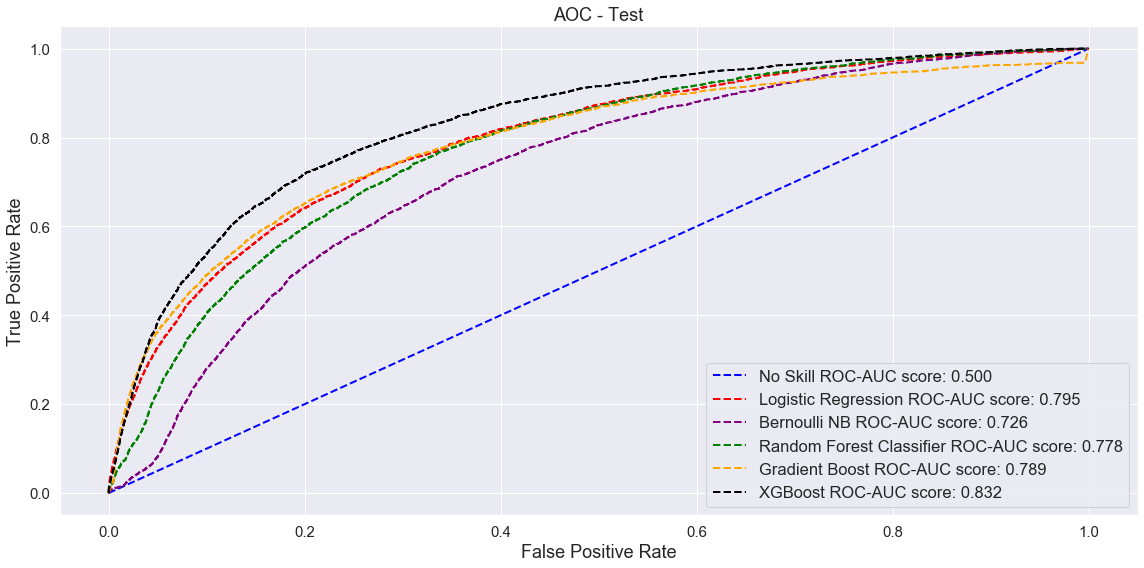

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=99)

model_train_test(
    X_train, X_test, y_train, y_test, X_, y_, 
    'AOC - Train', 'AOC - Test', 'images/AOC_train_prelim', 'images/AOC_test_prelim'
)

# Balanced - Undersampled Approach

## CV score

In [68]:
                        
cross_val_score(pipe_lr, X_under, y_under, cv=5, scoring='roc_auc', n_jobs=-1)
                        

array([0.6897399 , 0.73889584, 0.75307377, 0.77347243, 0.81257371])

### Models

No Skill ROC-AUC score: 0.500
Logistic Regression ROC-AUC score: 0.830
Bernoulli NB ROC-AUC score: 0.777
Random Forest Classifier ROC-AUC score: 0.850
Gradient Boost ROC-AUC score: 0.870
XGBoost ROC-AUC score: 0.865
Saving figure images/AOC_train_balanced


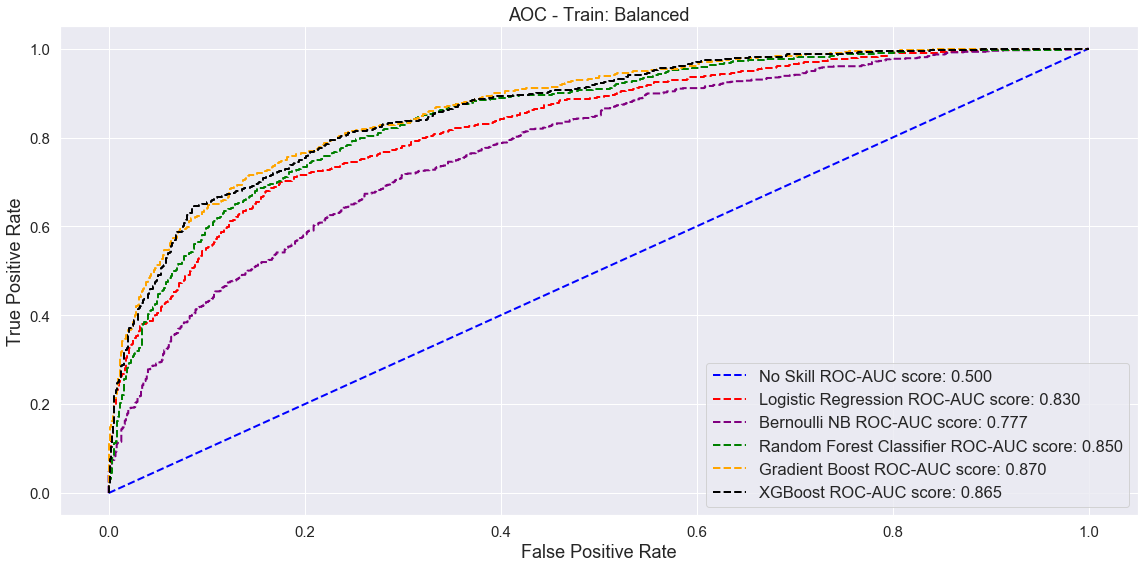

No Skill ROC-AUC score: 0.500
Logistic Regression ROC-AUC score: 0.791
Bernoulli NB ROC-AUC score: 0.775
Random Forest Classifier ROC-AUC score: 0.821
Gradient Boost ROC-AUC score: 0.832
XGBoost ROC-AUC score: 0.832
Saving figure images/AOC_test_balanced


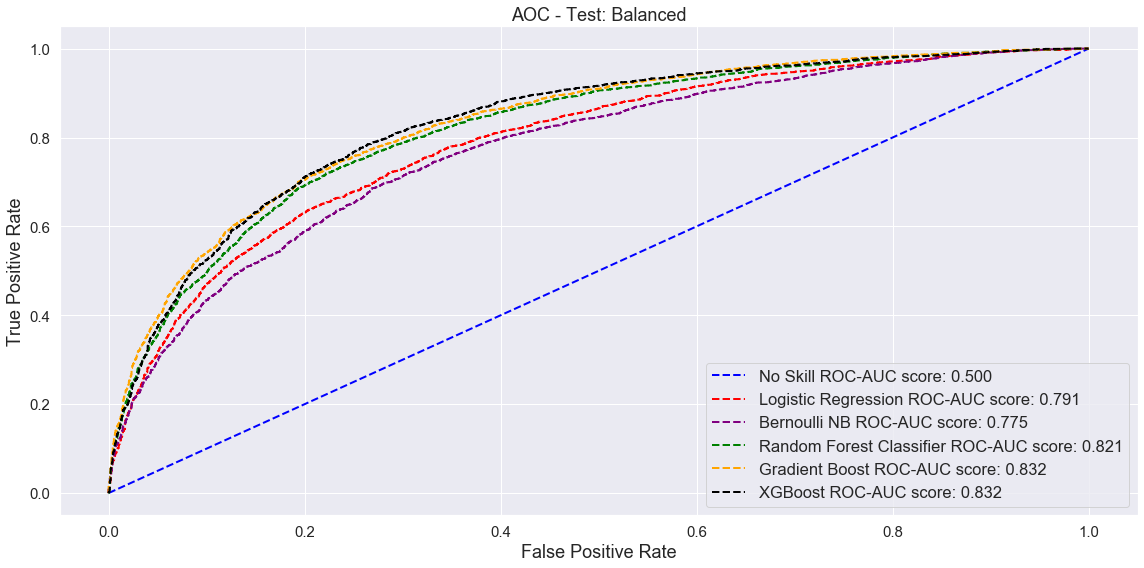

In [137]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.25, random_state=99)

model_train_test(
    X_train_under, X_test_under, y_train_under, y_test_under, X_under_, y_under_, 
    'AOC - Train: Balanced', 'AOC - Test: Balanced', 'images/AOC_train_balanced', 'images/AOC_test_balanced'
)



# Balanced - Clustered Approach

### CV score

In [76]:
                        
cross_val_score(pipe_lr, X_res, y_res, cv=5, scoring='roc_auc', n_jobs=-1)
                        

array([0.76532738, 0.83177083, 0.66982116, 0.8561848 , 0.87891207])

### Models

No Skill ROC-AUC score: 0.500
Logistic Regression ROC-AUC score: 0.995
Bernoulli NB ROC-AUC score: 1.000
Random Forest Classifier ROC-AUC score: 1.000
Gradient Boost ROC-AUC score: 0.983
XGBoost ROC-AUC score: 1.000
Saving figure images/AOC_train_cluster


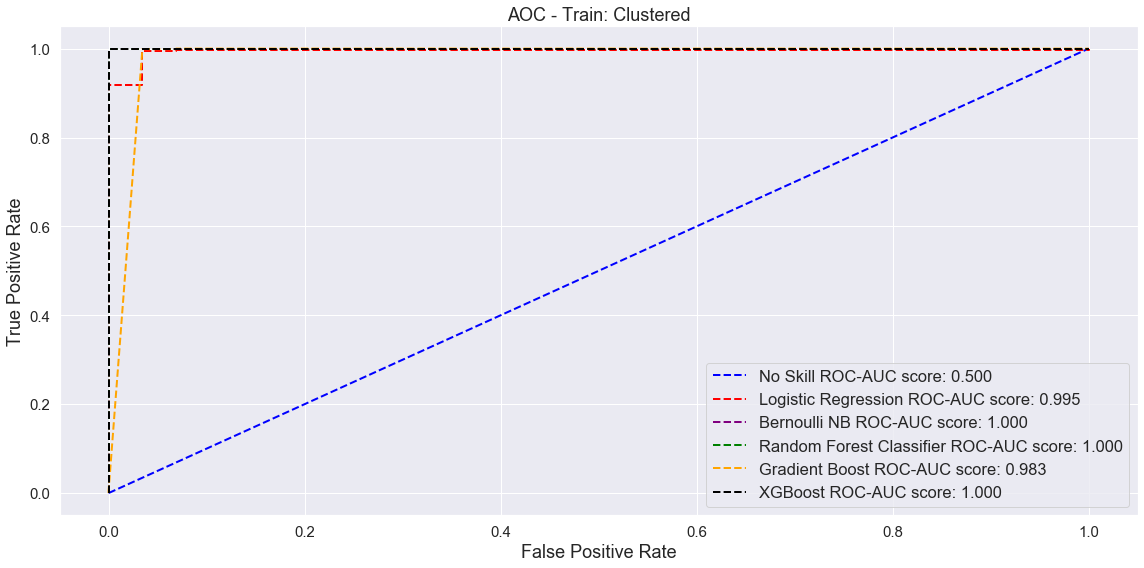

No Skill ROC-AUC score: 0.500
Logistic Regression ROC-AUC score: 0.989
Bernoulli NB ROC-AUC score: 0.995
Random Forest Classifier ROC-AUC score: 1.000
Gradient Boost ROC-AUC score: 1.000
XGBoost ROC-AUC score: 1.000
Saving figure images/AOC_test_cluster


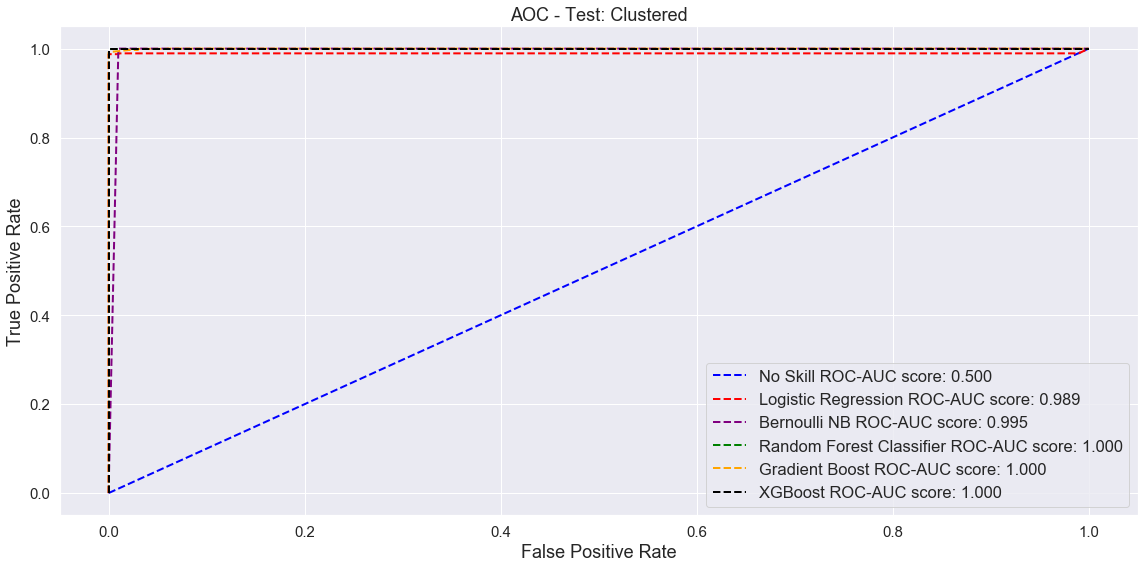

In [77]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.25, random_state=99)

model_train_test(
    X_train_res, X_test_res, y_train_res, y_test_res, X_res_, y_res_,
    'AOC - Train: Clustered', 'AOC - Test: Clustered', 'images/AOC_train_cluster', 'images/AOC_test_cluster'
)

# All Defaults - Undersampled Approach

### CV

In [78]:
pipe_lr = make_pipeline(LogisticRegression(random_state=99, max_iter=1000))
                        
cross_val_score(pipe_lr, X2_under, y2_under, cv=5, scoring='roc_auc', n_jobs=-1)

array([0.6267452 , 0.80728783, 0.79396236, 0.76949201, 0.79655307])

### Models

No Skill ROC-AUC score: 0.500
Logistic Regression ROC-AUC score: 0.886
Bernoulli NB ROC-AUC score: 0.831
Random Forest Classifier ROC-AUC score: 0.892
Gradient Boost ROC-AUC score: 0.945
XGBoost ROC-AUC score: 0.952
Saving figure images/AOC_train_allrandom


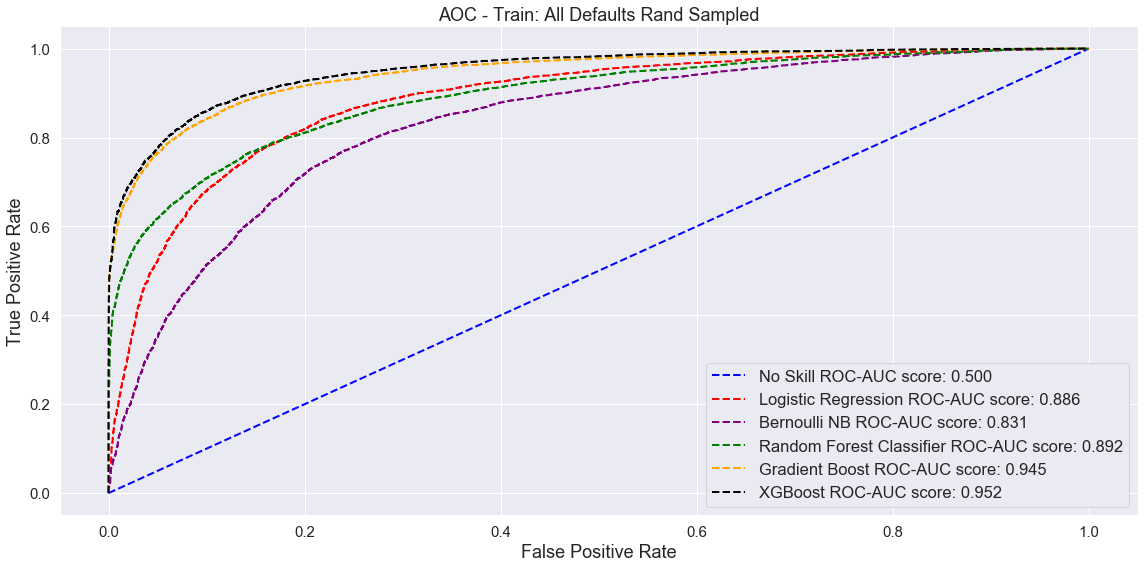

No Skill ROC-AUC score: 0.500
Logistic Regression ROC-AUC score: 0.728
Bernoulli NB ROC-AUC score: 0.658
Random Forest Classifier ROC-AUC score: 0.726
Gradient Boost ROC-AUC score: 0.821
XGBoost ROC-AUC score: 0.837
Saving figure images/AOC_test_allrandom


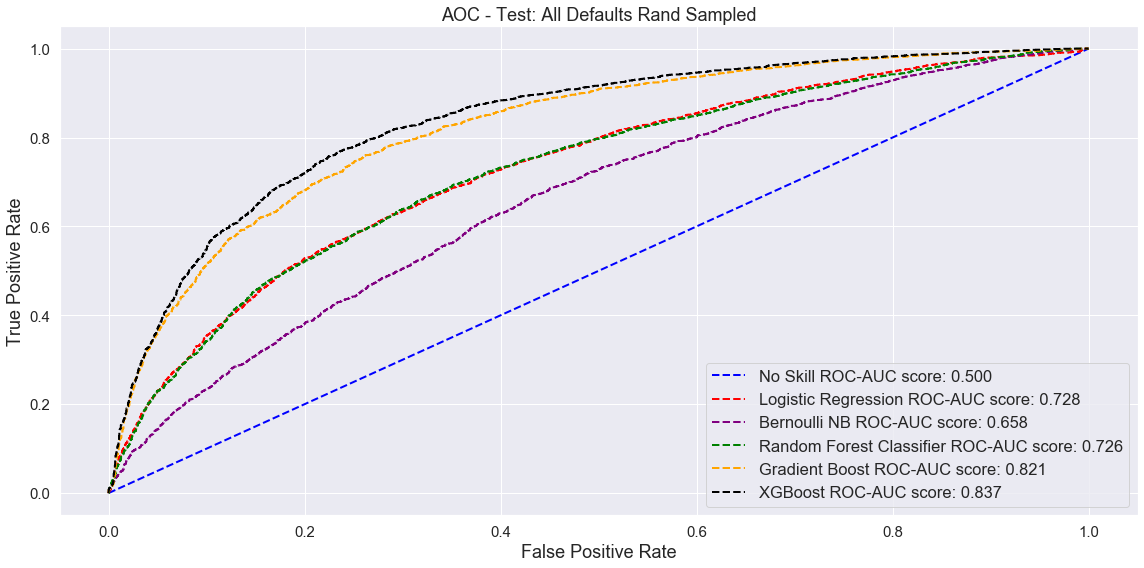

In [138]:
X2_train_under, X2_test_under, y2_train_under, y2_test_under = train_test_split(X2_under, y2_under, test_size=0.25, random_state=99)

model_train_test(
    X2_train_under, X2_test_under, y2_train_under, y2_test_under, X2_under_, y2_under_,
    'AOC - Train: All Defaults Rand Sampled', 'AOC - Test: All Defaults Rand Sampled', 
    'images/AOC_train_allrandom', 'images/AOC_test_allrandom'
)



# All Defaults - Clustered Approach

### CV

In [80]:
pipe_lr = make_pipeline(LogisticRegression(random_state=99, max_iter=1000))
                        
cross_val_score(pipe_lr, X2_res, y2_res, cv=5, scoring='roc_auc', n_jobs=-1)
        

array([0.6267452 , 0.80728783, 0.79396236, 0.76949201, 0.79655307])

### Models

No Skill ROC-AUC score: 0.500
Logistic Regression ROC-AUC score: 0.886
Bernoulli NB ROC-AUC score: 0.831
Random Forest Classifier ROC-AUC score: 0.892
Gradient Boost ROC-AUC score: 0.945
XGBoost ROC-AUC score: 0.953
Saving figure images/AOC_train_allcluster


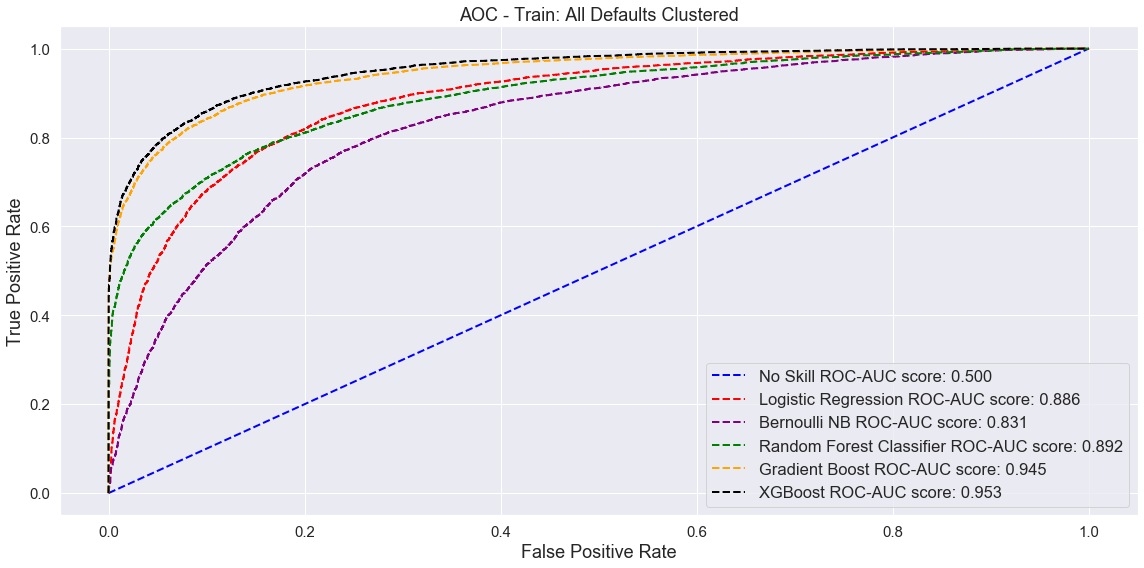

No Skill ROC-AUC score: 0.500
Logistic Regression ROC-AUC score: 0.728
Bernoulli NB ROC-AUC score: 0.658
Random Forest Classifier ROC-AUC score: 0.726
Gradient Boost ROC-AUC score: 0.821
XGBoost ROC-AUC score: 0.828
Saving figure images/AOC_test_allcluster


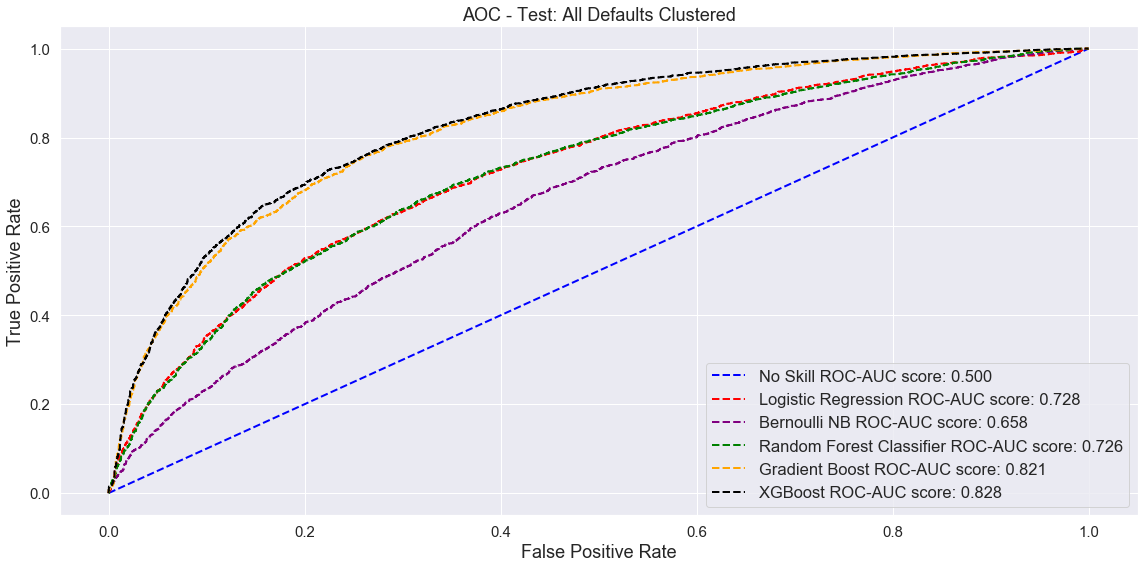

In [81]:
X2_train_res, X2_test_res, y2_train_res, y2_test_res = train_test_split(X2_res, y2_res, test_size=0.25, random_state=99)

model_train_test(
    X2_train_res, X2_test_res, y2_train_res, y2_test_res, X2_res_, y2_res_,
    'AOC - Train: All Defaults Clustered', 'AOC - Test: All Defaults Clustered',
    'images/AOC_train_allcluster', 'images/AOC_test_allcluster'
)

# Hyperparameter XGBoost

In [113]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

params={
    'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
    'max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15],
    'min_child_weight': [ 1, 3, 5, 7 ],
    'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    'colsample_bytree': [ 0.3, 0.4, 0.5 , 0.7 ]  
}

In [114]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [115]:
classifier = XGBRegressor()

In [97]:
random_search = RandomizedSearchCV(
    classifier, param_distributions=params, n_iter=5, 
    scoring='roc_auc', n_jobs=-1, cv=5, verbose=3
)

In [122]:
grid_search = GridSearchCV(
    classifier, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3
)

In [116]:
from datetime import datetime

start_time = timer(None)
random_search.fit(X2_under, y2_under)
timer(start_time)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  3.3min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.7min finished



 Time taken: 0 hours 6 minutes and 15.09 seconds.


In [117]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [118]:
random_search.best_params_

{'min_child_weight': 7,
 'max_depth': 12,
 'learning_rate': 0.05,
 'gamma': 0.3,
 'colsample_bytree': 0.7}

XGBoost ROC-AUC score: 0.952
Saving figure images/AOC_train_xgboost


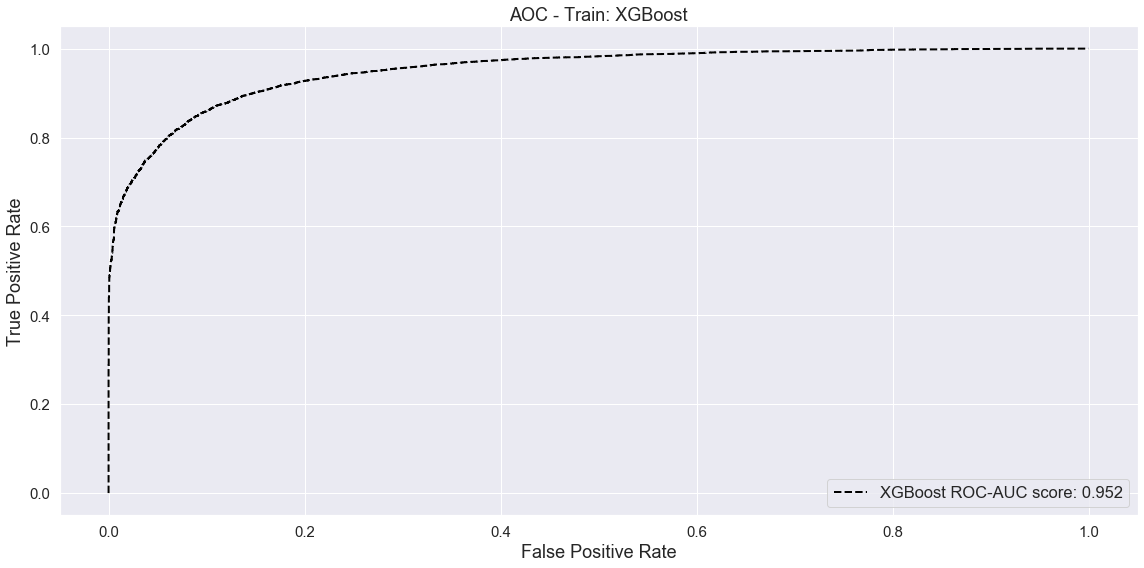

XGBoost ROC-AUC score: 0.837
Saving figure images/AOC_test_xgboost


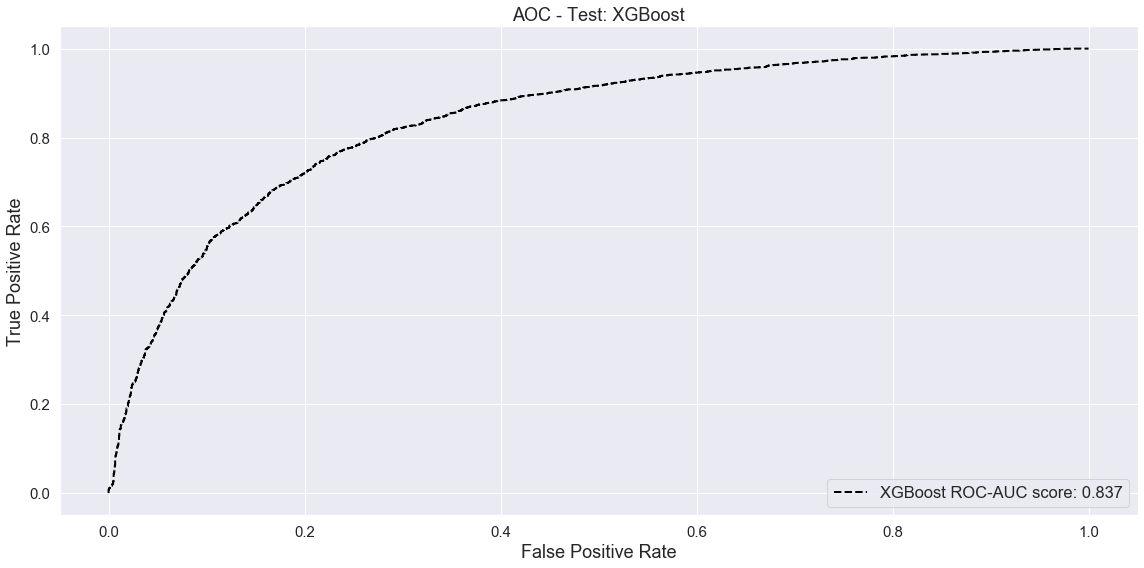

In [135]:
pipe_xgb = make_pipeline(StandardScaler(), 
                         XGBRegressor(
    base_score=0.5, booster='gbtree', colsample_bylevel=1,
    colsample_bynode=1, colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
    importance_type='gain', interaction_constraints='',
    learning_rate=0.05, max_delta_step=0, max_depth=12,
    min_child_weight=7, monotone_constraints='()',
    n_estimators=100, n_jobs=0, num_parallel_tree=1,
    objective='binary:logistic', random_state=0, reg_alpha=0,
    reg_lambda=1, scale_pos_weight=1, subsample=1,
    tree_method='exact', validate_parameters=1, verbosity=None, eval_metric='auc'
                         ))

# XGBoost
pipe_xgb.fit(X2_train_under, y2_train_under)
test_xgb = pipe_xgb.predict(X2_test_under)

# graph

# generate a no skill prediction
ns_probs = [0 for _ in range(len(y2_test_under))]

# calculate scores
xgb_auc = roc_auc_score(y2_test_under, test_xgb)
xgb = 'XGBoost ROC-AUC score: %.3f' % xgb_auc
print(xgb)

# calculate roc curves
xgb_fpr, xgb_tpr, _ = roc_curve(y2_test_under, test_xgb)

# fig size
plt.figure(figsize=(16,8))

# plot the roc curve for the model
plt.plot(xgb_fpr, xgb_tpr, linestyle='--', label=xgb, color='black')

plt.title('AOC - Train: XGBoost', fontsize=18)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc='lower right')
# show the plot
save_fig('images/AOC_train_xgboost')
plt.show()    

test_xgbt = pipe_xgb.predict(X2_under_)

# generate a no skill prediction
nst_probs = [0 for _ in range(len(y2_under_))]

# calculate scores
xgbt_auc = roc_auc_score(y2_under_, test_xgbt)

xgbt = 'XGBoost ROC-AUC score: %.3f' % xgbt_auc


print(xgbt)

# calculate roc curves
xgbt_fpr, xgbt_tpr, _ = roc_curve(y2_under_, test_xgbt)

# fig size
plt.figure(figsize=(16,8))

# plot the roc curve for the model
plt.plot(xgbt_fpr, xgbt_tpr, linestyle='--', label=xgbt, color='black')

plt.title('AOC - Test: XGBoost', fontsize=18)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc='lower right')
# show the plot
save_fig('images/AOC_test_xgboost')
plt.show()





[0.09151033 0.01191606 0.00531161 0.0079152  0.00777048 0.00610784
 0.00535626 0.01837011 0.0062373  0.01571713 0.00885879 0.00407533
 0.00410176 0.01063662 0.00965028 0.00674205 0.00388116 0.00488768
 0.00374456 0.03526617 0.         0.00518523 0.         0.00845407
 0.0050243  0.0034685  0.0051066  0.00357227 0.00635689 0.00456956
 0.         0.         0.         0.00250949 0.         0.00732108
 0.         0.         0.00756489 0.         0.00507807 0.00613545
 0.00834265 0.         0.00676882 0.         0.         0.
 0.         0.01153378 0.00787431 0.         0.         0.00777085
 0.         0.         0.         0.         0.01083817 0.
 0.         0.01116224 0.         0.         0.         0.00153421
 0.         0.         0.         0.         0.         0.00790528
 0.         0.         0.0093767  0.         0.         0.
 0.         0.         0.00349804 0.         0.00560051 0.
 0.         0.         0.00587476 0.         0.         0.
 0.         0.         0.         0

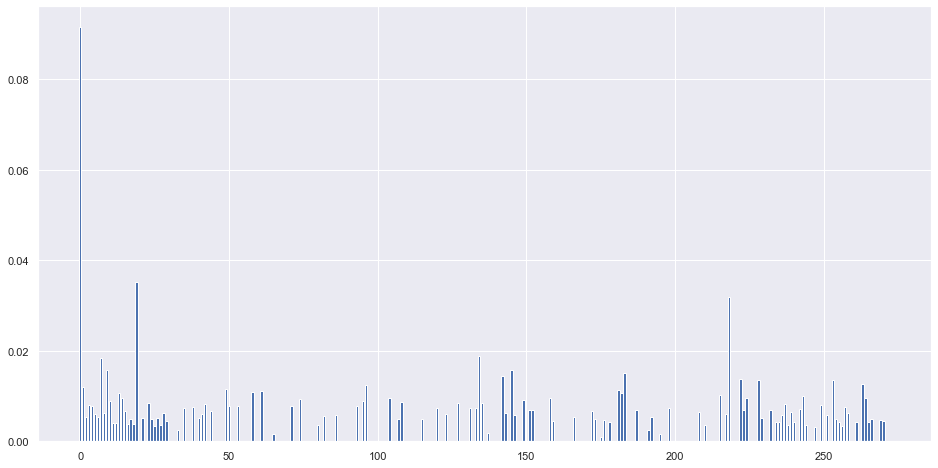

In [157]:

# # feature importance
# print(pipe_xgb.steps[1][1].feature_importances_)
# # plot
# plt.bar(range(len(pipe_xgb.steps[1][1].feature_importances_)), pipe_xgb.steps[1][1].feature_importances_)
# plt.show()

## Deep Neural network with 4 layers

4 layers with 2 hidden layer and the hidden layer has 80 neurons 


In [158]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

In [ ]:
len(target_test)

In [159]:


features_train = np.array(X2_under)
target_train = np.array(y2_under)


features_test = np.array(X2_under_)
target_test = np.array(y2_under_)



In [160]:
#feature scaling

scaler = MinMaxScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [161]:
features_train.shape[-1]

273

In [162]:
target_train.shape

(56396,)

In [163]:
model = Sequential()
model.add(Dense(80, input_dim=features_train.shape[-1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [186]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [187]:
model.fit(features_train_scaled, target_train, epochs=50)

Epoch 1/50
56396/56396 [==============================] - 2s 34us/step - loss: 0.3108 - accuracy: 0.8700
Epoch 2/50
56396/56396 [==============================] - 2s 29us/step - loss: 0.3022 - accuracy: 0.8735
Epoch 3/50
56396/56396 [==============================] - 2s 34us/step - loss: 0.2964 - accuracy: 0.8754
Epoch 4/50
56396/56396 [==============================] - 2s 30us/step - loss: 0.2919 - accuracy: 0.8778
Epoch 5/50
56396/56396 [==============================] - 2s 31us/step - loss: 0.2856 - accuracy: 0.8795
Epoch 6/50
56396/56396 [==============================] - 2s 30us/step - loss: 0.2826 - accuracy: 0.8818
Epoch 7/50
56396/56396 [==============================] - 2s 30us/step - loss: 0.2799 - accuracy: 0.8817
Epoch 8/50
56396/56396 [==============================] - 2s 31us/step - loss: 0.2751 - accuracy: 0.8850
Epoch 9/50
56396/56396 [==============================] - 2s 32us/step - loss: 0.2728 - accuracy: 0.8865
Epoch 10/50
56396/56396 [==============================

In [188]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                21920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                6480      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 81        
Total params: 28,481
Trainable params: 28,481
Non-trainable params: 0
_________________________________________________________________


In [189]:
test_loss, test_acc = model.evaluate(features_test_scaled, target_test)

print('Test accuracy:', test_acc)

6572/6572 [==============================] - 0s 16us/step
Test accuracy: 0.6905051469802856


In [190]:
predictions = model.predict(features_test_scaled)

In [191]:
from sklearn.metrics import accuracy_score
accuracy_score(target_test, predictions.round())

0.6905051734631771

In [192]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(target_test, predictions.round())
cnf_matrix

array([[2738,  548],
       [1486, 1800]])

In [193]:
TN, FP, FN, TP = confusion_matrix(target_test, predictions.round()).ravel() 
TN, FP, FN, TP

(2738, 548, 1486, 1800)

In [194]:
#Area Under the Receiver Operating Characteristic Curve (ROC AUC)

roc_auc_score(target_test, predictions)

0.7546126079803693

## Deep Neural network with 5 layers
5 layers with 3 hidden layers, first and second hidden layer has 80 neurons and third hidden layer has 40 neurons

In [195]:
model_1 = Sequential()
model_1 .add(Dense(80, input_dim=features_train.shape[-1], activation='relu'))
model_1 .add(Dropout(0.2))
model_1 .add(Dense(80, activation='relu'))
model_1 .add(Dropout(0.2))
model_1 .add(Dense(40, activation='relu'))
model_1 .add(BatchNormalization())
model_1 .add(Dense(1, activation='sigmoid'))

In [196]:
model_1.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [197]:
model_1.fit(features_train_scaled, target_train, epochs=50)

Epoch 1/50
56396/56396 [==============================] - 3s 49us/step - loss: 0.4962 - accuracy: 0.7661
Epoch 2/50
56396/56396 [==============================] - 2s 41us/step - loss: 0.4064 - accuracy: 0.8233
Epoch 3/50
56396/56396 [==============================] - 2s 41us/step - loss: 0.3602 - accuracy: 0.8484
Epoch 4/50
56396/56396 [==============================] - 2s 40us/step - loss: 0.3414 - accuracy: 0.8570
Epoch 5/50
56396/56396 [==============================] - 2s 40us/step - loss: 0.3313 - accuracy: 0.8631
Epoch 6/50
56396/56396 [==============================] - 2s 42us/step - loss: 0.3267 - accuracy: 0.8649
Epoch 7/50
56396/56396 [==============================] - 3s 45us/step - loss: 0.3170 - accuracy: 0.8678
Epoch 8/50
56396/56396 [==============================] - 3s 47us/step - loss: 0.3122 - accuracy: 0.8707
Epoch 9/50
56396/56396 [==============================] - 2s 38us/step - loss: 0.3062 - accuracy: 0.8728
Epoch 10/50
56396/56396 [==============================

In [198]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 80)                21920     
_________________________________________________________________
dropout_5 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 80)                6480      
_________________________________________________________________
dropout_6 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 40)                3240      
_________________________________________________________________
batch_normalization_2 (Batch (None, 40)                160       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [199]:
preds = model_1.predict(features_test_scaled)

In [200]:
test_loss, test_acc = model_1.evaluate(features_test_scaled,target_test)

print('Test accuracy:', test_acc)

6572/6572 [==============================] - 0s 23us/step
Test accuracy: 0.6968958973884583


In [201]:
TN, FP, FN, TP = confusion_matrix(target_test, preds.round()).ravel() 
TN, FP, FN, TP

(2703, 583, 1409, 1877)

In [202]:
roc_auc_score(target_test, preds)

0.7749333752925135